In [1]:
import torchaudio
torchaudio.set_audio_backend("soundfile")
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from torch.nn import functional as F
import torch
print(torch.__version__)
from torch import nn
from tqdm import tqdm
from torch.optim import Adam,SGD,RMSprop
import matplotlib.pyplot as plt
import os
import warnings
import gc
from copy import deepcopy
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import OneHotEncoder
import librosa
import numpy as np
import noisereduce as nr
import malaya_speech
from malaya_speech import Pipeline
import IPython.display as ipd
warnings.filterwarnings("ignore")
from pysptk.sptk import rapt
from efficientnet_pytorch import EfficientNet
import gc
import random

1.8.0+cu111


In [2]:
seed = 529 #沛茵生日 
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
set_seed(seed)

# path

In [3]:
X_train_dir = 'train/train/'
X_test_dir = 'public_test/public_test/'
Y_train_path = 'train/meta_train.csv'

# load data

In [4]:
def preprocessing_X(wav_dir):
    files = os.listdir(wav_dir)
    files.sort() #正確排序很重要!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
    X = torch.FloatTensor([])
    for f in tqdm(files[:]):
        try:
            samples, sample_rate = malaya_speech.load(X_train_dir+f)
            melspectrogram = wav2featuresflow(samples,sr=sample_rate)
            melspectrogram = melspectrogram.reshape(-1,80,157).copy()
            melspectrogram = torch.from_numpy(melspectrogram)
            X = torch.cat([X,torch.unsqueeze(melspectrogram,0)],dim=0)
            gc.collect()
        except:
            print(f)
    print('X shape:',X.shape)
    return X

def preprocessing_Y(file_path):
    Y = pd.read_csv(file_path).iloc[:,:]
    Y = Y[Y.Filename != 'train_01046']
    enc = OneHotEncoder().fit(Y[['Label']])
    Y_one_hot = enc.transform(Y[['Label']]).toarray()
    Y_one_hot = torch.FloatTensor(Y_one_hot)
    print('Y_ont_hot shape',Y_one_hot.shape)
    print('Y_df shape',Y.shape)
    return Y_one_hot,Y

In [5]:
X_train_all = torch.load('X_train_吳啟聖教的方法.pt')
X_test_all = torch.load('X_test_吳啟聖教的方法.pt')
gc.collect()

20

In [6]:
Y_train_all,Y_train_df = preprocessing_Y(Y_train_path)
print(Y_train_all.shape)
map_dict = {}
for l in Y_train_df.Label.unique():
    map_dict[l] = Y_train_df[Y_train_df.Label==l].sample(1)['Remark'].values[0]
map_dict

Y_ont_hot shape torch.Size([1199, 6])
Y_df shape (1199, 3)
torch.Size([1199, 6])


{0: 'Barking',
 1: 'Howling',
 2: 'Crying',
 3: 'COSmoke',
 4: 'GlassBreaking',
 5: 'Cat'}

In [7]:
Y_test_all = pd.read_csv('vote_V12_排行榜0.976667.csv') #拿目前分數最高的
Y_test_all.head(5)

,Filename,Barking,Howling,Crying,COSmoke,GlassBreaking,Other
0,public_00001,0.015718,0.024436,0.072592,0.006425,0.405442,0.475387
1,public_00002,0.069019,0.005622,0.061248,0.055104,0.008110,0.800898
2,public_00003,0.843593,0.002444,0.003287,0.077840,0.058815,0.014021
3,public_00004,0.038729,0.004414,0.054868,0.041895,0.116355,0.743739
4,public_00005,0.535658,0.010625,0.426786,0.003237,0.003602,0.020091


In [8]:
values = Y_test_all.iloc[:,1:].values.argmax(axis=1) #轉換成one hot格式
n_values = np.max(values) + 1
np.eye(n_values)[values][:5]

array([[0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0., 0.]])

In [9]:
Y_test_all.iloc[:,1:] = np.eye(n_values)[values] #轉換成df格式
Y_test_all

,Filename,Barking,Howling,Crying,COSmoke,GlassBreaking,Other
0,public_00001,0.0,0.0,0.0,0.0,0.0,1.0
1,public_00002,0.0,0.0,0.0,0.0,0.0,1.0
2,public_00003,1.0,0.0,0.0,0.0,0.0,0.0
3,public_00004,0.0,0.0,0.0,0.0,0.0,1.0
4,public_00005,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...
29995,private_19996,0.0,0.0,0.0,0.0,0.0,1.0
29996,private_19997,0.0,0.0,0.0,0.0,0.0,1.0
29997,private_19998,0.0,0.0,0.0,0.0,0.0,1.0
29998,private_19999,0.0,0.0,0.0,0.0,0.0,1.0


In [10]:
Y_test_all = torch.FloatTensor(Y_test_all.iloc[:10000,1:].values) #轉換成tensor格式
Y_test_all,Y_test_all.shape

(tensor([[0., 0., 0., 0., 0., 1.],
         [0., 0., 0., 0., 0., 1.],
         [1., 0., 0., 0., 0., 0.],
         ...,
         [0., 1., 0., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0.]]), torch.Size([10000, 6]))

# help functions

In [11]:
def norm_mel(y, sr):
    mel = librosa.feature.melspectrogram(y, sr = sr, n_mels = 80,hop_length=512)
    mel = librosa.power_to_db(mel, ref=np.max)
    return mel.T

def plot(y, sr):
    mel = norm_mel(y, sr)
    fig, axs = plt.subplots(2, figsize=(10, 8))
    axs[0].plot(y)
    im = axs[1].imshow(np.rot90(mel), aspect='auto', interpolation='none')
    fig.colorbar(mappable=im, shrink=0.65, orientation='horizontal', ax=axs[1])
    print('mel shape:',mel.shape)
    plt.show()

# 靜音部分消除
quantized_model = malaya_speech.vad.deep_model(model = 'vggvox-v2', quantized = True)
p = Pipeline()

pipeline_left = (
    p.map(malaya_speech.generator.frames, frame_duration_ms = 30, sample_rate = 16000)
)

pipeline_right = (
    pipeline_left.batching(5)
    .foreach_map(quantized_model.predict)
    .flatten()
)

pipeline_left.foreach_zip(pipeline_right).map(malaya_speech.combine.without_silent,
                                             threshold_to_stop = 0.05)
def remove_silent(y,sr,time_length=80000):
    y =  p(y)['without_silent']
    if len(y) > time_length:
        y = y[0:0+time_length]
    else:
        y = np.pad(y, (0,time_length-len(y)))
    return y

def wav2featuresflow(y, sr):
    y_without_silent = remove_silent(y,sr)
    melspectrogram = np.rot90(norm_mel(y, sr))
    return melspectrogram



from sklearn.metrics import confusion_matrix,accuracy_score
def plot_confusion_matrix(model,data_iter,map_dict=map_dict):
    y_true = np.array([])
    y_pred = np.array([])
    for bx,by in tqdm(data_iter):
        bx = bx.to(device)
        by = by.to(device)
        y_hat = model(bx)
        try:
            if len(y_true) == 0:
                y_true = by.argmax(axis=1).detach().cpu().numpy()
                y_pred = y_hat.argmax(axis=1).detach().cpu().numpy()
            else:
                y_true = np.hstack((y_true,by.argmax(axis=1).detach().cpu().numpy()))
                y_pred = np.hstack((y_pred,y_hat.argmax(axis=1).detach().cpu().numpy()))
        except:
            pass
    cm = pd.DataFrame(confusion_matrix(y_pred,y_true))
    cm.columns = list(map_dict.values())
    acc = accuracy_score(y_pred,y_true)
    return cm,acc

def 找超參數(search_iteration=30,max_epochs=30):
    import optuna
    sampler = optuna.samplers.CmaEsSampler()
    study = optuna.create_study(sampler=sampler,direction='maximize')
    for i in tqdm(range(search_iteration)):
        trial = study.ask()
        lr = trial.suggest_uniform('lr',1e-5,1e-2)
        valid_size = trial.suggest_uniform('valid_size',0.1,0.5)
        batch_size = trial.suggest_int("batch_size", 16, 128)
        X_train, X_valid , y_train, y_valid = train_test_split(X_train_all, Y_train_all,
                                                               test_size = valid_size, 
                                                               random_state = 1,
                                                               stratify=Y_train_all)
        trainset = TensorDataset(torch.FloatTensor(X_train.to(torch.float32)),torch.FloatTensor(y_train))
        vaildset = TensorDataset(torch.FloatTensor(X_valid.to(torch.float32)),torch.FloatTensor(y_valid))
        train_iter = DataLoader(trainset,batch_size=batch_size,num_workers=4)
        vaild_iter = DataLoader(vaildset,batch_size=batch_size,num_workers=4)
        model = torch.hub.load('moskomule/senet.pytorch','se_resnet20',num_classes=6)
        model.conv1 = nn.Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        device = 'cuda:0'
        model = model.to(device)
        model = torch.nn.DataParallel(model, device_ids=[0, 1, 2 ,3])
        optimizer = Adam(model.parameters(),lr=lr)
        loss_fn = nn.BCEWithLogitsLoss()
        model = train(model,train_iter,vaild_iter,optimizer,loss_fn,max_epochs=max_epochs,log_interval=1,device=device)
        model.eval()
        cm,acc = plot_confusion_matrix(model.to(device),vaild_iter)
        study.tell(trial,acc)
        print(study.best_params,study.best_value)
    return study.best_params,study.best_value

# train valid split

In [12]:
from sklearn.model_selection import train_test_split

# 訓練驗證切分
a = X_test_all
b = Y_test_all

X_valid = X_train_all #1199驗證
y_valid = Y_train_all #1199驗證

X_train = a #10000訓練
y_train = b #10000訓練

use_idx = np.random.choice([*range(len(X_train))], 9000, replace=False) #訓練集可能有錯所以抽9000筆

X_train = X_train[use_idx]
y_train = y_train[use_idx]

print(X_train.shape)
print(X_valid.shape)
print(pd.DataFrame(y_train.argmax(axis=1)).value_counts())
print(pd.DataFrame(y_valid.argmax(axis=1)).value_counts())

torch.Size([9000, 1, 80, 157])
torch.Size([1199, 1, 80, 157])
5    3276
2    1729
1    1409
0    1285
3     826
4     475
dtype: int64
0    200
1    200
2    200
3    200
5    200
4    199
dtype: int64


#  create pytorch dataloader and save

In [13]:
from torch.utils.data import TensorDataset,DataLoader
trainset = TensorDataset(torch.FloatTensor(X_train.to(torch.float32)),torch.FloatTensor(y_train))
vaildset = TensorDataset(torch.FloatTensor(X_valid.to(torch.float32)),torch.FloatTensor(y_valid))
train_iter = DataLoader(trainset,batch_size=32,num_workers=4)
vaild_iter = DataLoader(vaildset,batch_size=32,num_workers=4)
for bx,by in train_iter:
    print(bx.shape,bx.device) # batch,channel,freq,time
    print(by.shape,by.device) # batch,n_class
    break

torch.Size([32, 1, 80, 157]) cpu
torch.Size([32, 6]) cpu


# define model

In [14]:
import torch.hub
model = torch.hub.load('moskomule/senet.pytorch','se_resnet20',num_classes=64)
#改模型
model.conv1 = nn.Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
model.fc = nn.Sequential(
    nn.Linear(64,64),
    nn.LeakyReLU(),
    nn.Dropout(0.5),#三個臭皮匠勝過一個諸葛亮
    nn.Linear(64,6))
print(model)
#初始化
for m in model.modules():
    if isinstance(m, (nn.Conv2d, nn.Linear)):
        print(m,'初始化')
        nn.init.xavier_uniform_(m.weight)
# forward test
y_hat = model(bx)
print(bx.shape,y_hat.shape)
y_hat.shape

Using cache found in /root/.cache/torch/hub/moskomule_senet.pytorch_master


CifarSEResNet(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (layer1): Sequential(
    (0): CifarSEBasicBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (se): SELayer(
        (avg_pool): AdaptiveAvgPool2d(output_size=1)
        (fc): Sequential(
          (0): Linear(in_features=16, out_features=1, bias=False)
          (1): ReLU(inplace=True)
          (2): Linear(in_features=1, out_features=16, bias=False)
          (3): Sigmoid()
        )
      )
    )
    (1)

torch.Size([32, 1, 80, 157]) torch.Size([32, 6])


torch.Size([32, 6])

# def train loop

In [15]:
from sklearn.metrics import accuracy_score

def train_step(model,train_iter,loss_fn,optimizer,device):
        model.train()
        total_loss = 0
        total_auc = 0
        for t,(x,y) in enumerate(train_iter):
            x,y = x.to(device),y.to(device)
            y_hat = model(x)
            total_auc += calculate_auc_score(model,x,y)
            loss = loss_fn(y_hat,y)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            total_loss += loss.item()
        return total_loss/(t+1) ,total_auc/(t+1)

def valid_step(model,vaild_iter,loss_fn,optimizer,device):
    model.eval()
    total_loss = 0
    total_auc = 0
    for t,(x,y) in enumerate(vaild_iter):
        x,y = x.to(device),y.to(device)
        y_hat = model(x)
        total_auc += calculate_auc_score(model,x,y)
        loss = loss_fn(y_hat,y)
        total_loss += loss.item()
    return total_loss/(t+1) ,total_auc/(t+1)

def softmax2onehot(probs):
  probs = torch.FloatTensor(probs)
  max_idx = torch.argmax(probs, 1, keepdim=True)
  one_hot = torch.FloatTensor(probs.shape)
  one_hot.zero_()
  one_hot.scatter_(1, max_idx, 1)
  return one_hot.detach().cpu().numpy().astype(int)

# calculate roc_auc_score
def calculate_auc_score(model,x,y):
    y_hat = model(x).argmax(dim=1).detach().cpu().numpy()
    y = y.argmax(dim=1).detach().cpu().numpy()
    return accuracy_score(y,y_hat)


# train_loop
def train(model,train_iter,vaild_iter,optimizer,loss_fn,max_epochs=300,log_interval=10,device=None):
        history = {
            'train_loss':[],
            'valid_loss':[],
            'train_auc':[],
            'valid_auc':[],
            }
        no_improve_count = 0
        current_auc = -np.inf
        best_model = None
        for i in tqdm(range(max_epochs)):
            # step
            train_loss,train_auc = train_step(model,train_iter,loss_fn,optimizer,device)
            valid_loss,valid_auc = valid_step(model,vaild_iter,loss_fn,optimizer,device)
            # record history
            history['train_loss'].append(train_loss)
            history['valid_loss'].append(valid_loss)
            history['train_auc'].append(train_auc)
            history['valid_auc'].append(valid_auc)
            # print info
            if i % log_interval == 0:
                print("epoch:{} train_loss:{:.4f} valid_loss:{:.4f} train_auc:{:.4f} valid_auc:{:.4f}".format(
                    i,history['train_loss'][-1],history['valid_loss'][-1],history['train_auc'][-1],history['valid_auc'][-1])
                    )
            # record the best model
            if history['valid_auc'][-1] >= current_auc:
                best_model = deepcopy(model.eval())
                current_auc = history['valid_auc'][-1]
                print('有進步')
            else:
                no_improve_count += 1
                print('沒進步')
                print(f'沒進步總計:{no_improve_count}')
                if no_improve_count >= 10:
                    print('10次沒進步,提早結束訓練')
                    break
            gc.collect()
        
        # copy best model
        model = deepcopy(best_model.eval())
        
        # plot loss
        plt.plot(history['train_loss'],label='train_loss')
        plt.plot(history['valid_loss'],label='valid_loss')
        plt.legend()
        plt.savefig('loss.jpg')
        plt.show()
        
         # plot auc
        plt.plot(history['train_auc'],label='train_auc')
        plt.plot(history['valid_auc'],label='valid_auc')
        plt.legend()
        plt.savefig('auc.jpg')
        plt.show()
        
        
        return model

In [16]:
device = 'cuda:0'
model = model.to(device)
model = torch.nn.DataParallel(model, device_ids=[0, 1, 2 ,3])

In [17]:
loss_fn = nn.BCEWithLogitsLoss()

  0%|          | 0/100 [00:00<?, ?it/s]

epoch:0 train_loss:0.3307 valid_loss:0.2259 train_auc:0.5709 valid_auc:0.6458
有進步


  1%|          | 1/100 [02:05<3:26:53, 125.39s/it]

epoch:1 train_loss:0.2344 valid_loss:0.1682 train_auc:0.7186 valid_auc:0.8013
有進步


  2%|▏         | 2/100 [03:47<3:02:50, 111.94s/it]

epoch:2 train_loss:0.2026 valid_loss:0.1362 train_auc:0.7532 valid_auc:0.8291
有進步


  3%|▎         | 3/100 [05:31<2:54:35, 108.00s/it]

epoch:3 train_loss:0.1848 valid_loss:0.1311 train_auc:0.7789 valid_auc:0.8478
有進步


  5%|▌         | 5/100 [08:56<2:45:56, 104.80s/it]

epoch:4 train_loss:0.1692 valid_loss:0.1507 train_auc:0.7979 valid_auc:0.8128
沒進步
沒進步總計:1
epoch:5 train_loss:0.1592 valid_loss:0.1204 train_auc:0.8097 valid_auc:0.8507
有進步


  7%|▋         | 7/100 [12:22<2:40:39, 103.65s/it]

epoch:6 train_loss:0.1506 valid_loss:0.1071 train_auc:0.8174 valid_auc:0.8803
有進步
epoch:7 train_loss:0.1407 valid_loss:0.0775 train_auc:0.8321 valid_auc:0.9126
有進步


  9%|▉         | 9/100 [15:49<2:37:18, 103.72s/it]

epoch:8 train_loss:0.1372 valid_loss:0.0992 train_auc:0.8393 valid_auc:0.8885
沒進步
沒進步總計:2


 10%|█         | 10/100 [17:33<2:35:27, 103.64s/it]

epoch:9 train_loss:0.1264 valid_loss:0.0792 train_auc:0.8556 valid_auc:0.9118
沒進步
沒進步總計:3


 11%|█         | 11/100 [19:17<2:33:56, 103.78s/it]

epoch:10 train_loss:0.1187 valid_loss:0.0948 train_auc:0.8614 valid_auc:0.8921
沒進步
沒進步總計:4


 12%|█▏        | 12/100 [21:00<2:31:51, 103.54s/it]

epoch:11 train_loss:0.1157 valid_loss:0.1049 train_auc:0.8614 valid_auc:0.8779
沒進步
沒進步總計:5
epoch:12 train_loss:0.1120 valid_loss:0.0852 train_auc:0.8750 valid_auc:0.9035
沒進步
沒進步總計:6


 14%|█▍        | 14/100 [24:28<2:28:54, 103.89s/it]

epoch:13 train_loss:0.1047 valid_loss:0.0946 train_auc:0.8798 valid_auc:0.9061
沒進步
沒進步總計:7


 15%|█▌        | 15/100 [26:13<2:27:26, 104.07s/it]

epoch:14 train_loss:0.1009 valid_loss:0.1062 train_auc:0.8866 valid_auc:0.8889
沒進步
沒進步總計:8


 16%|█▌        | 16/100 [27:56<2:25:04, 103.62s/it]

epoch:15 train_loss:0.0953 valid_loss:0.0988 train_auc:0.8938 valid_auc:0.8997
沒進步
沒進步總計:9


 16%|█▌        | 16/100 [29:38<2:35:35, 111.14s/it]

epoch:16 train_loss:0.0957 valid_loss:0.1085 train_auc:0.8920 valid_auc:0.9038
沒進步
沒進步總計:10
10次沒進步,提早結束訓練


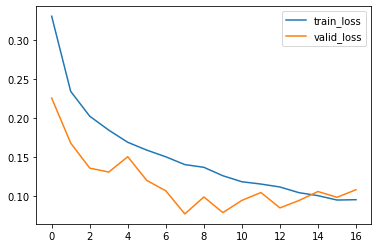

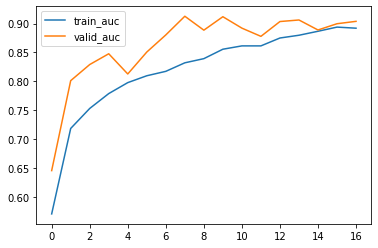

In [18]:
optimizer = Adam(model.parameters(),lr=1e-3)
model = train(model,train_iter,vaild_iter,optimizer,loss_fn,max_epochs=100,log_interval=1,device=device)

# model infernce test

In [19]:
model.eval()
cm,acc = plot_confusion_matrix(model.to(device),train_iter)
print(acc)
cm

100%|██████████| 282/282 [00:35<00:00,  7.93it/s]

0.881


,Barking,Howling,Crying,COSmoke,GlassBreaking,Cat
0,1006,12,73,2,26,133
1,89,1301,84,2,1,46
2,46,40,1476,3,0,9
3,21,24,26,810,15,48
4,36,0,1,1,371,75
5,87,32,69,8,62,2965


In [20]:
cm,acc = plot_confusion_matrix(model.to(device),vaild_iter)
print(acc)
cm

100%|██████████| 38/38 [00:07<00:00,  5.26it/s]

0.9132610508757297


,Barking,Howling,Crying,COSmoke,GlassBreaking,Cat
0,183,9,5,1,7,4
1,9,178,27,0,0,2
2,4,10,165,1,0,5
3,2,0,0,196,0,0
4,2,0,0,0,192,8
5,0,3,3,2,0,181


# submit

In [21]:
print(X_test_all.shape[0])

10000


In [22]:
print(X_train.shape[0])

9000


In [23]:
print(X_valid.shape[0])

1199


In [24]:
X_test = X_test_all

In [25]:
sample_submit = pd.read_csv('sample_submission.csv')
model = model.to('cuda:0')
model.eval()
batch = 100
for i in tqdm(range(0,X_test.shape[0]-batch+1,batch)):
    sample_submit.iloc[i:i+batch,1:] = model(X_test[i:i+batch].to(torch.float32).cuda()).detach().cpu().numpy()
sample_submit

100%|██████████| 100/100 [00:12<00:00,  7.92it/s]


,Filename,Barking,Howling,Crying,COSmoke,GlassBreaking,Other
0,public_00001,-8.680025,-8.028159,-9.513109,-8.211393,-4.146655,4.061665
1,public_00002,-9.105474,-10.699864,-9.230936,-8.137550,-7.347707,5.126243
2,public_00003,2.568177,-4.935860,-6.005966,-6.932211,-5.833771,-7.174024
3,public_00004,-9.248781,-11.139863,-8.936531,-6.768234,-5.849737,4.448127
4,public_00005,0.001591,-4.066350,-0.755488,-6.142711,-6.651887,-4.539632
...,...,...,...,...,...,...,...
29995,private_19996,0.166600,0.166600,0.166600,0.166600,0.166600,0.167000
29996,private_19997,0.166600,0.166600,0.166600,0.166600,0.166600,0.167000
29997,private_19998,0.166600,0.166600,0.166600,0.166600,0.166600,0.167000
29998,private_19999,0.166600,0.166600,0.166600,0.166600,0.166600,0.167000


In [26]:
from scipy.special import softmax
a = softmax(sample_submit.iloc[:,1:].values,axis=1)
a

array([[2.92570082e-06, 5.61476653e-06, 1.27182127e-06, 4.67470375e-06,
        2.72300039e-04, 9.99713213e-01],
       [6.59539452e-07, 1.33907850e-07, 5.81772927e-07, 1.73622051e-06,
        3.82498181e-06, 9.99993064e-01],
       [9.98903416e-01, 5.50252063e-04, 1.88721043e-04, 7.47406970e-05,
        2.24183609e-04, 5.86866365e-05],
       ...,
       [1.66655554e-01, 1.66655554e-01, 1.66655554e-01, 1.66655554e-01,
        1.66655554e-01, 1.66722230e-01],
       [1.66655554e-01, 1.66655554e-01, 1.66655554e-01, 1.66655554e-01,
        1.66655554e-01, 1.66722230e-01],
       [1.66655554e-01, 1.66655554e-01, 1.66655554e-01, 1.66655554e-01,
        1.66655554e-01, 1.66722230e-01]])

In [27]:
sample_submit.iloc[:,1:] = a
sample_submit

,Filename,Barking,Howling,Crying,COSmoke,GlassBreaking,Other
0,public_00001,2.925701e-06,5.614767e-06,1.271821e-06,0.000005,0.000272,0.999713
1,public_00002,6.595395e-07,1.339078e-07,5.817729e-07,0.000002,0.000004,0.999993
2,public_00003,9.989034e-01,5.502521e-04,1.887210e-04,0.000075,0.000224,0.000059
3,public_00004,1.125866e-06,1.699027e-07,1.538492e-06,0.000013,0.000034,0.999950
4,public_00005,6.665589e-01,1.140654e-02,3.126390e-01,0.001430,0.000860,0.007106
...,...,...,...,...,...,...,...
29995,private_19996,1.666556e-01,1.666556e-01,1.666556e-01,0.166656,0.166656,0.166722
29996,private_19997,1.666556e-01,1.666556e-01,1.666556e-01,0.166656,0.166656,0.166722
29997,private_19998,1.666556e-01,1.666556e-01,1.666556e-01,0.166656,0.166656,0.166722
29998,private_19999,1.666556e-01,1.666556e-01,1.666556e-01,0.166656,0.166656,0.166722


In [28]:
sample_submit.iloc[122]

Filename         public_00123
Barking              0.003852
Howling              0.000078
Crying               0.000063
COSmoke              0.000076
GlassBreaking        0.002919
Other                0.993013
Name: 122, dtype: object

In [29]:
sample_submit.sum(axis=1)

0        1.0
1        1.0
2        1.0
3        1.0
4        1.0
        ... 
29995    1.0
29996    1.0
29997    1.0
29998    1.0
29999    1.0
Length: 30000, dtype: float64

In [37]:
acc

0.9132610508757297

In [38]:
import time # 引入time

time_stamp = time.time() # 設定timeStamp
struct_time = time.localtime(time_stamp) # 轉成時間元組
timeString = time.strftime("%Y-%m-%d-%H-%M-%S", struct_time) # 轉成字串
print(timeString)

2021-06-09-01-16-42


In [39]:
# save
sample_submit.to_csv(f'senet20_{timeString}_random_state{seed}_validacc_{acc}_用訓練資料1199當驗證集.csv',index=False)
torch.save(model.state_dict(),f'senet20_{timeString}_random_state{seed}_validacc_{acc}用訓練資料1199當驗證集.pt')
print('done')

done
